In [ ]:
!pip install do_mpc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
import do_mpc
#from math import *
from casadi import *

In [2]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [3]:
q1 = model.set_variable(var_type='_x', var_name='q1', shape=(1,1))
q2 = model.set_variable(var_type='_x', var_name='q2', shape=(1,1))
q3 = model.set_variable(var_type='_x', var_name='q3', shape=(1,1))
# Variables can also be vectors:
dq = model.set_variable(var_type='_x', var_name='dq', shape=(3,1))
# Two states for the desired (set) torque:
#u1 = model.set_variable(var_type='_tvp', var_name='u1')
#u2 = model.set_variable(var_type='_tvp', var_name='u2')
#u3 = model.set_variable(var_type='_tvp', var_name='u3')
#u = vertcat(tau1, tau2, tau3)
q_des1 = model.set_variable(var_type='_u', var_name='q_des1', shape=(1,1))
q_des2 = model.set_variable(var_type='_u', var_name='q_des2', shape=(1,1))
q_des3 = model.set_variable(var_type='_u', var_name='q_des3', shape=(1,1))

# Two additional states for the true motor position:
#q_1_m = model.set_variable(var_type='_x', var_name='q_1_m', shape=(1,1))
#q_2_m = model.set_variable(var_type='_x', var_name='q_2_m', shape=(1,1))

m3 = model.set_variable('parameter', 'm3')
dc3 = model.set_variable('parameter', 'dc3')
I3zz = model.set_variable('parameter', 'I3zz')

In [4]:
from numpy.matrixlib.defmatrix import matrix
# We define the other parameters
m1 = 6
m2 = 6

L1 = 1
L2 = 1
L3 = 1

I1zz = 2
I2zz = 2

dc1 = 0.5
dc2 = 0.5

g0 = 9.81



"""M = SX([[ I1zz + I2zz + I3zz + (L1**2)*m2 + (L1**2)*m3 + (L2**2)*m3 + dc1**2*m1 + dc2**2*m2 + power(dc3,2)*m3 + 2*L1*dc3*m3*cos(q2 + q3) + 2*L1*L2*m3*cos(q2) + 2*L1*dc2*m2*cos(q2) + 2*L2*dc3*m3*cos(q3), m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz, I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3))],
              [                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz,                                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + m2*dc2**2 + m3*power(dc3,2) + I2zz + I3zz,                   I3zz + dc3*m3*(dc3 + L2*cos(q3))],
              [                                                                                                                                         I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3)),                                                                                                  I3zz + dc3*m3*(dc3 + L2*cos(q3)),                                    m3*power(dc3,2) + I3zz]])

c = np.array([[- L1*dc3*m3*dq[1]**2*sin(q2 + q3) - L1*dc3*m3*dq[2]**2*sin(q2 + q3) - L1*L2*m3*dq[1]**2*sin(q2) - L1*dc2*m2*dq[1]**2*sin(q2) - L2*dc3*m3*dq[2]**2*sin(q3) - 2*L1*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) - 2*L1*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) - 2*L1*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) - 2*L1*L2*m3*dq[0]*dq[1]*sin(q2) - 2*L1*dc2*m2*dq[0]*dq[1]*sin(q2) - 2*L2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*L2*dc3*m3*dq[1]*dq[2]*sin(q3)],
              [                                                                                                                                                                                                                                      L1*dc3*m3*dq[0]**2*sin(q2 + q3) + L1*L2*m3*dq[0]**2*sin(q2) + L1*dc2*m2*dq[0]**2*sin(q2) - L2*dc3*m3*dq[2]**2*sin(q3) - 2*L2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*L2*dc3*m3*dq[1]*dq[2]*sin(q3)],
              [                                                                                                                                                                                                                                                                                                                         dc3*m3*(L1*dq[0]**2*sin(q2 + q3) + L2*dq[0]**2*sin(q3) + L2*dq[1]**2*sin(q3) + 2*L2*dq[0]*dq[1]*sin(q3))]])
 
g = np.array([[g0*m3*(L2*cos(q1 + q2) + L1*cos(q1) + dc3*cos(q1 + q2 + q3)) + g0*m2*(dc2*cos(q1 + q2) + L1*cos(q1)) + dc1*g0*m1*cos(q1)],
              [                                                g0*m3*(L2*cos(q1 + q2) + dc3*cos(q1 + q2 + q3)) + dc2*g0*m2*cos(q1 + q2)],
              [                                                                                             dc3*g0*m3*cos(q1 + q2 + q3)]])

"""


'M = SX([[ I1zz + I2zz + I3zz + (L1**2)*m2 + (L1**2)*m3 + (L2**2)*m3 + dc1**2*m1 + dc2**2*m2 + power(dc3,2)*m3 + 2*L1*dc3*m3*cos(q2 + q3) + 2*L1*L2*m3*cos(q2) + 2*L1*dc2*m2*cos(q2) + 2*L2*dc3*m3*cos(q3), m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz, I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(q3))],\n              [                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + L1*m3*cos(q2)*L2 + m2*dc2**2 + L1*m2*cos(q2)*dc2 + m3*power(dc3,2) + L1*m3*cos(q2 + q3)*dc3 + I2zz + I3zz,                                                                 m3*(L2**2) + 2*m3*cos(q3)*L2*dc3 + m2*dc2**2 + m3*power(dc3,2) + I2zz + I3zz,                   I3zz + dc3*m3*(dc3 + L2*cos(q3))],\n              [                                                                                                                                         I3zz + dc3*m3*(dc3 + L1*cos(q2 + q3) + L2*cos(

In [5]:
model.set_rhs('q1', dq[0])
model.set_rhs('q2', dq[1])
model.set_rhs('q3', dq[2])

#qdd = np.matmul(np.invert(M), u-g-c)

tau = 1e-2
taud = 2e-1

#u1 = 1/tau*(q_des1 - q1) + 1/taud*dq[0]
#u2 = 1/tau*(q_des2 - q2) + 1/taud*dq[1]
#u3 = 1/tau*(q_des3 - q3) + 1/taud*dq[2]

#model.set_rhs('q_des1', sin(q_des1))

dq_next = vertcat(
     
 (((981*dc3*m3*cos(q1 + q2 + q3))/100 - 1/tau*(q_des3 - q3) + 1/taud*dq[2] + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*(3*I3zz*cos(q2) - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((7*I3zz)/2 + I3zz*m3 + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2)*(1/tau*(q_des1 - q1) - 1/taud*dq[0] - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((2943*cos(q1 + q2))/100 - 1/tau*(q_des2 - q2) + 1/taud*dq[1] + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*((7*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 (((7*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (7*dc3**2*m3)/2 + dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)*cos(q3))*(1/tau*(q_des1 - q1) - 1/taud*dq[0] - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((981*dc3*m3*cos(q1 + q2 + q3))/100 - 1/tau*(q_des3 - q3) + 1/taud*dq[2] + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*((19*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (19*dc3**2*m3)/2 + dc3**2*m3**2 + (19*dc3*m3*cos(q3))/2 - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3*m3**2*cos(q3) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - dc3*m3**2*cos(q2 + q3)*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) - 3*dc3*m3*cos(q2 + q3)*cos(q2) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) + (((2943*cos(q1 + q2))/100 - 1/tau*(q_des2 - q2) + 1/taud*dq[1] + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*(13*I3zz + 2*I3zz*m3 + 6*I3zz*cos(q2) + 13*dc3**2*m3 + 2*dc3**2*m3**2 - dc3**2*m3**2*cos(q3)**2 + 6*dc3**2*m3*cos(q2) + 2*dc3**2*m3**2*cos(q2) + 2*I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - 2*dc3**2*m3**2*cos(q2 + q3)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 (((981*dc3*m3*cos(q1 + q2 + q3))/100 - 1/tau*(q_des3 - q3) + 1/taud*dq[2] + dc3*m3*(dq[0]**2*sin(q3) + dq[1]**2*sin(q3) + dq[0]**2*sin(q2 + q3) + 2*dq[0]*dq[1]*sin(q3)))*((19*I3zz)/2 + 13*m3 - 6*m3*cos(q2)**2 + I3zz*m3 - 9*cos(q2)**2 - m3**2*cos(q2)**2 + (19*dc3**2*m3)/2 + m3**2 + (dc3**2)*(m3**2) + 19*dc3*m3*cos(q3) + 2*dc3*(m3**2)*cos(q3) - (dc3**2)*(m3**2)*(cos(q2 + q3)**2) - 2*dc3*(m3**2)*cos(q2 + q3)*cos(q2) - 6*dc3*m3*cos(q2 + q3)*cos(q2) + 133/4))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*(dc3**2)*(m3**2) - (dc3**2)*(m3**3) + 6*(dc3**2)*(m3**2)*(cos(q2)**2) + (19*(dc3**2)*(m3**2)*cos(q3)**2)/2 + (dc3**2)*(m3**3)*cos(q2)**2 + (dc3**2)*(m3**3)*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*(m3**2)*cos(q2)**2 + 9*(dc3**2)*m3*cos(q2)**2 + (7*(dc3**2)*(m3**2)*cos(q2 + q3)**2)/2 + (dc3**2)*(m3**3)*cos(q2 + q3)**2 - 6*(dc3**2)*(m3**2)*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - ((3*I3zz*cos(q2) - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) + 3*dc3*m3*cos(q2)*cos(q3))*(1/tau*(q_des1 - q1) - 1/taud*dq[0] - (2943*cos(q1 + q2))/100 - (8829*cos(q1))/100 + 3*dq[1]**2*sin(q2) - (981*m3*(cos(q1 + q2) + cos(q1) + dc3*cos(q1 + q2 + q3)))/100 + 6*dq[0]*dq[1]*sin(q2) + m3*dq[1]**2*sin(q2) + 2*m3*dq[0]*dq[1]*sin(q2) + dc3*m3*dq[1]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q2 + q3) + dc3*m3*dq[2]**2*sin(q3) + 2*dc3*m3*dq[0]*dq[1]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q2 + q3) + 2*dc3*m3*dq[0]*dq[2]*sin(q3) + 2*dc3*m3*dq[1]*dq[2]*sin(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)) - (((2943*cos(q1 + q2))/100 - 1/tau*(q_des2 - q2) + 1/taud*dq[1] + 3*dq[0]**2*sin(q2) + (981*m3*(cos(q1 + q2) + dc3*cos(q1 + q2 + q3)))/100 + m3*dq[0]**2*sin(q2) + dc3*m3*dq[0]**2*sin(q2 + q3) - dc3*m3*dq[2]**2*sin(q3) - 2*dc3*m3*dq[0]*dq[2]*sin(q3) - 2*dc3*m3*dq[1]*dq[2]*sin(q3))*((19*I3zz)/2 + I3zz*m3 + 3*I3zz*cos(q2) + (19*dc3**2*m3)/2 + dc3**2*m3**2 + (19*dc3*m3*cos(q3))/2 - dc3*m3**2*cos(q2 + q3) + 3*dc3**2*m3*cos(q2) + dc3*m3**2*cos(q3) + dc3**2*m3**2*cos(q2) - (7*dc3*m3*cos(q2 + q3))/2 + I3zz*m3*cos(q2) - dc3**2*m3**2*cos(q2 + q3)**2 - dc3*m3**2*cos(q2 + q3)*cos(q2) + dc3*m3**2*cos(q2)*cos(q3) - dc3**2*m3**2*cos(q2 + q3)*cos(q3) - 3*dc3*m3*cos(q2 + q3)*cos(q2) + 3*dc3*m3*cos(q2)*cos(q3)))/(9*I3zz*cos(q2)**2 - 13*I3zz*m3 - I3zz*m3**2 - (133*dc3**2*m3)/4 - (133*I3zz)/4 - 13*dc3**2*m3**2 - dc3**2*m3**3 + 6*dc3**2*m3**2*cos(q2)**2 + (19*dc3**2*m3**2*cos(q3)**2)/2 + dc3**2*m3**3*cos(q2)**2 + dc3**2*m3**3*cos(q3)**2 + 6*I3zz*m3*cos(q2)**2 + I3zz*m3**2*cos(q2)**2 + 9*dc3**2*m3*cos(q2)**2 + (7*dc3**2*m3**2*cos(q2 + q3)**2)/2 + dc3**2*m3**3*cos(q2 + q3)**2 - 6*dc3**2*m3**2*cos(q2 + q3)*cos(q2)*cos(q3) - 2*dc3**2*m3**3*cos(q2 + q3)*cos(q2)*cos(q3)),
 
)

model.set_rhs('dq', dq_next)


In [6]:
model.setup()

In [7]:
# Controller

mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

mterm = q1**2 + q2**2 + q3**2
lterm = q1**2 + q2**2 + q3**2

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(
    q_des1=1e-2,
    q_des2=1e-2,
    q_des3=1e-2
)

In [8]:
# constraints
# Lower bounds on states:
mpc.bounds['lower','_x', 'q1'] = -2*np.pi
mpc.bounds['lower','_x', 'q2'] = -2*np.pi
mpc.bounds['lower','_x', 'q3'] = -2*np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'q1'] = 2*np.pi
mpc.bounds['upper','_x', 'q2'] = 2*np.pi
mpc.bounds['upper','_x', 'q3'] = 2*np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'q_des1'] = -2*np.pi
mpc.bounds['lower','_u', 'q_des2'] = -2*np.pi
mpc.bounds['lower','_u', 'q_des3'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'q_des1'] = 2*np.pi
mpc.bounds['upper','_u', 'q_des2'] = 2*np.pi
mpc.bounds['upper','_u', 'q_des3'] = 2*np.pi

mpc.scaling['_x', 'q1'] = 2
mpc.scaling['_x', 'q2'] = 2
mpc.scaling['_x', 'q3'] = 2

# unceartain parameters
inertia_mass_3 = 2+np.array([1., 0.9, 1.1])
mass_3 = 6+np.array([1., 0.9, 1.1])
distance_CoM = 0.5 - 0.5*np.array([1., 0.9, 1.1])/(6+np.array([1., 0.9, 1.1]))

mpc.set_uncertainty_values(
    m3 = mass_3,
    dc3 = distance_CoM,
    I3zz = inertia_mass_3
)

mpc.setup()

In [9]:
#### Simulator part
####

simulator = do_mpc.simulator.Simulator(model)
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

p_template = simulator.get_p_template()

def p_fun(t_now):
    delta_mass = 2*np.random.randn()
    p_template['m3'] = 6 + delta_mass
    p_template['dc3'] = 0.5 - 0.5*delta_mass/(6+delta_mass)
    p_template['I3zz'] = 2 + delta_mass
    return p_template

simulator.set_p_fun(p_fun)

simulator.setup()

In [10]:
# Creating the control loop

x0 = np.pi*np.array([1, 1, -1.5, 0, 0, 0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()


In [11]:
# Setting up the graphics
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)



In [12]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

In [13]:
%%capture
for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (q1, q2, q2) on the first axis:
    g.add_line(var_type='_x', var_name='q1', axis=ax[0])
    g.add_line(var_type='_x', var_name='q2', axis=ax[0])
    g.add_line(var_type='_x', var_name='q3', axis=ax[0])

    # Plot the set torques (u1, u2) on the second axis:
    g.add_line(var_type='_u', var_name='q_des1', axis=ax[1])
    g.add_line(var_type='_u', var_name='q_des2', axis=ax[1])
    g.add_line(var_type='_u', var_name='q_des3', axis=ax[1])


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('torque [Nm]')
ax[1].set_xlabel('time [s]')

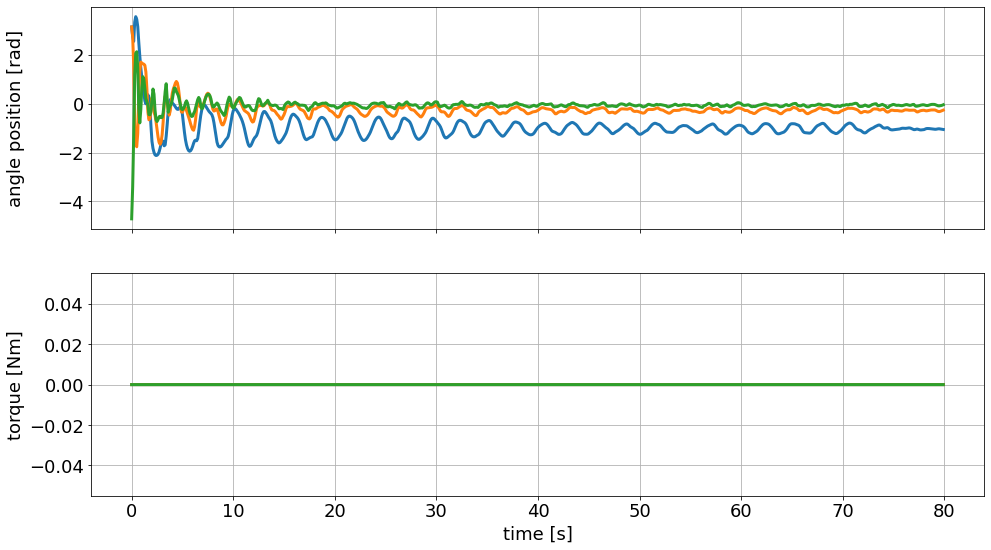

In [14]:
# Running the simulation

u0 = np.zeros((3,1))
for i in range(800):
    simulator.make_step(u0)

sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes()
# Show the figure:
fig


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    61566
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    30624

Total number of variables............................:    15228
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     7857
                     variables with only upper bounds:        0
Total number of equa

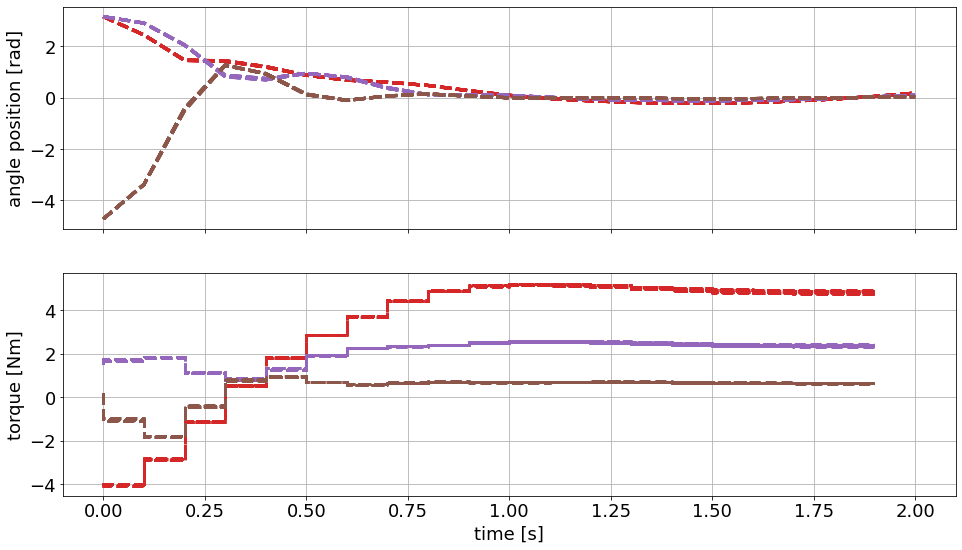

In [15]:
# Running the optimizer

u0 = mpc.make_step(x0)

sim_graphics.clear()

mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()
# Show the figure:
fig

In [16]:
# Change the color for the three states:
for line_i in mpc_graphics.pred_lines['_x', 'q1']: line_i.set_color('#1f77b4') # blue
for line_i in mpc_graphics.pred_lines['_x', 'q2']: line_i.set_color('#ff7f0e') # orange
for line_i in mpc_graphics.pred_lines['_x', 'q3']: line_i.set_color('#2ca02c') # green
# Change the color for the two inputs:
for line_i in mpc_graphics.pred_lines['_u', 'q_des1']: line_i.set_color('#1f77b4')
for line_i in mpc_graphics.pred_lines['_u', 'q_des2']: line_i.set_color('#ff7f0e')
for line_i in mpc_graphics.pred_lines['_u', 'q_des3']: line_i.set_color('#2ca02c')

# Make all predictions transparent:
for line_i in mpc_graphics.pred_lines.full: line_i.set_alpha(0.2)

In [17]:
# Get line objects (note sum of lists creates a concatenated list)
lines = sim_graphics.result_lines['_x', 'phi_1']+sim_graphics.result_lines['_x', 'phi_2']+sim_graphics.result_lines['_x', 'phi_3']

ax[0].legend(lines,'123',title='disc')

# also set legend for second subplot:
lines = sim_graphics.result_lines['_u', 'phi_m_1_set']+sim_graphics.result_lines['_u', 'phi_m_2_set']
ax[1].legend(lines,'12',title='motor')

In [18]:
# running the control loop

simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [ ]:
%%capture
for i in range(20):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)

In [ ]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig